In [81]:
from sympy.functions.special.error_functions import erf
from fewfermions.simulate.numerics import discrete_hamiltonian
from scipy import sparse

In [110]:
from helpers_merging import *

initial_power = 100* si.uW
initial_waist = 1.1*si.uW
initial_distance = 4*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,
    power_tweezer2 = initial_power,
    waist_tweezer1 = initial_waist,
    waist_tweezer2 = initial_waist,
    distance_tweezers = initial_distance,

    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)

left_cutoff = -0.5*initial_distance-3*float(trap.subs(trap.waist_tweezer1))
right_cutoff = 0.5*initial_distance+3*float(trap.subs(trap.waist_tweezer2))

x, y, z = trap.x, trap.y, trap.z

In [111]:
trap.get_potential().subs({trap.power:0,trap.grad_z:0, trap.grad_r:0})

a*(2*P_t1*exp(-d_t**2/(2*W_t1**2))/(pi*W_t1**2) + 2*P_t2*exp(-d_t**2/(2*W_t2**2))/(pi*W_t2**2)) - a*(2*P_t1*exp((-2*y**2 - 2*(d_t/2 + x)**2)/(W_t1**2*(1 + lambda**2*z**2/(pi**2*W_t1**4))))/(pi*W_t1**2*(1 + lambda**2*z**2/(pi**2*W_t1**4))) + 2*P_t2*exp((-2*y**2 - 2*(-d_t/2 + x)**2)/(W_t2**2*(1 + lambda**2*z**2/(pi**2*W_t2**4))))/(pi*W_t2**2*(1 + lambda**2*z**2/(pi**2*W_t2**4)))) - g*m*z

In [112]:
trap.subs(trap.get_potential(apply_zero_offset=False)).subs({y:0,z:0})

-9.24016432665953e-29*exp(-1652892561983.47*(x + 2.0e-6)**2)/pi - 9.24016432665953e-29*exp(-1652892561983.47*(x - 2.0e-6)**2)/pi

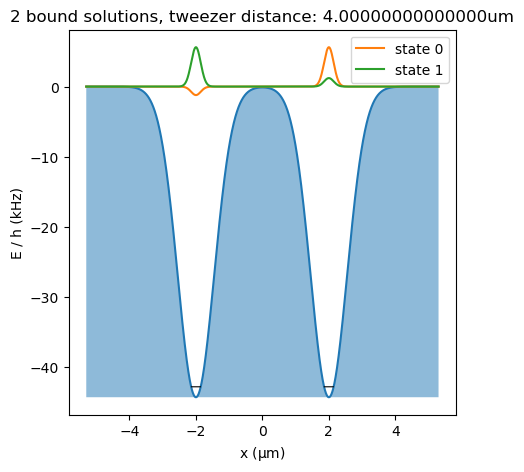

In [113]:
trap[trap.distance_tweezers] = initial_distance
plot_solutions(trap,2,left_cutoff,right_cutoff,display_plot=-1,state_mult=40,n_pot_steps=2000,plot=True,ret_results=False)

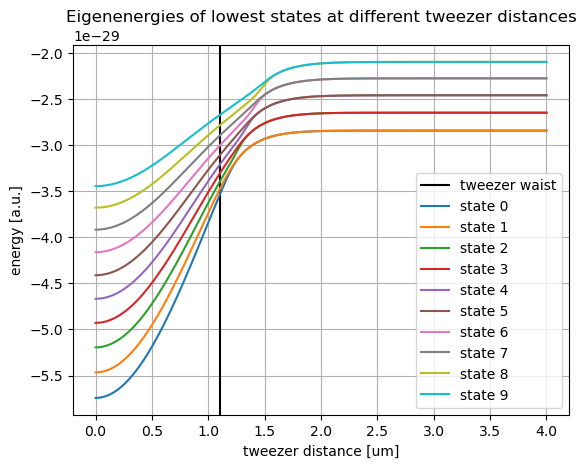

In [114]:
n_levels=10
n_pot_steps=2000
x_np = np.linspace(left_cutoff,right_cutoff,n_pot_steps)

distances = np.linspace(0*si.um,initial_distance,500)
energies = np.zeros((len(distances),n_levels))
states = np.zeros((len(distances),n_levels,n_pot_steps))
potential = np.zeros((len(distances),n_pot_steps))

#diagonalise hamiltonian for all distances
for i, dist in enumerate(distances):
    trap[trap.distance_tweezers] = dist
    num, ener, state, pot = plot_solutions(trap,n_levels,np.min(x_np),np.max(x_np),display_plot=0,state_mult=450,n_pot_steps=n_pot_steps,plot=False,ret_results=True)
    energies[i,:len(ener)] = ener
    states[i,:len(ener)] = state
    potential[i] = pot(x_np)


#plot eigenenergies
plt.axvline(float(trap.subs(trap.waist_tweezer1))/si.um, color="black",label="tweezer waist")
for i in range(n_levels):
    plt.plot(distances/si.um,energies[:,i],label=f"state {i}")

plt.title("Eigenenergies of lowest states at different tweezer distances")
plt.xlabel("tweezer distance [um]")
plt.ylabel("energy [a.u.]")

plt.grid()
plt.legend()
plt.show()

In [108]:
-trap.a*np.sqrt(2/np.pi)/initial_distance/trap.waist_tweezer1/trap.waist_tweezer2* (trap.power_tweezer1*trap.waist_tweezer2*(erf((initial_distance-2*x)/np.sqrt(2)/trap.waist_tweezer1) +
                                                                                                                             erf(np.sqrt(2)*x/trap.waist_tweezer1))
                                                                                    + trap.power_tweezer2*trap.waist_tweezer1*(erf((initial_distance+2*x)/np.sqrt(2)/trap.waist_tweezer2) -
                                                                                                                             erf(np.sqrt(2)*x/trap.waist_tweezer2)))

-1139835.08686124*a*(P_t1*W_t2*(erf(1.4142135623731*x/W_t1) + erf((4.94974746830583e-7 - 1.41421356237309*x)/W_t1)) + P_t2*W_t1*(-erf(1.4142135623731*x/W_t2) + erf((1.41421356237309*x + 4.94974746830583e-7)/W_t2)))/(W_t1*W_t2)

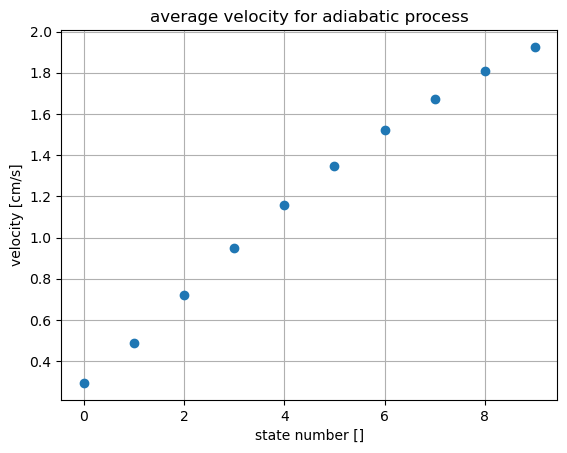

In [109]:
#calculate average potential as tweezer distance is decreased from "initial_distance" to zero
average_pot = sp.lambdify(x,trap.subs(-trap.a*np.sqrt(2/np.pi)/initial_distance/trap.waist_tweezer1/trap.waist_tweezer2* (trap.power_tweezer1*trap.waist_tweezer2*(erf((initial_distance-2*x)/np.sqrt(2)/trap.waist_tweezer1) +
                                                                                                                             erf(np.sqrt(2)*x/trap.waist_tweezer1))
                                                                                    + trap.power_tweezer2*trap.waist_tweezer1*(erf((initial_distance+2*x)/np.sqrt(2)/trap.waist_tweezer2) -
                                                                                                                             erf(np.sqrt(2)*x/trap.waist_tweezer2)))))

#average_pot = sp.lambdify(y,trap.subs(-trap.a*np.sqrt(2/np.pi)/initial_distance*((trap.power_tweezer1/trap.waist_tweezer1*erf((initial_distance-2*y)/np.sqrt(2)/trap.waist_tweezer1)) +
#                                                                                    (trap.power_tweezer2/trap.waist_tweezer2*erf((initial_distance+2*y)/np.sqrt(2)/trap.waist_tweezer2)))))
average_potential = average_pot(x_np)
#plt.plot(x_np,average_potential)

#get the time averaged hamiltonian
dx = np.mean(np.diff(x_np))
mean_ham = discrete_hamiltonian(dx,average_potential,float(trap.subs(trap.m).evalf()))
mean_ham_square = mean_ham**2

#compute the time "tau" needed to make it an adiabatic process
delta_ham = np.zeros(n_levels)
for i in range(n_levels):
    delta_ham[i] = np.sqrt(states[-1,i].dot(mean_ham_square.dot(states[-1,i]))-(states[-1,i].dot(mean_ham.dot(states[-1,i])))**2)
tau = const.hbar/delta_ham

"""
plt.plot(tau/si.us,"o")
plt.xlabel("state number []")
plt.ylabel("time [us]")
plt.title("time needed for adiabatic process")"""


plt.plot(initial_distance/si.cm/tau,"o")
plt.xlabel("state number []")
plt.ylabel("velocity [cm/s]")
plt.title("average velocity for adiabatic process")

plt.grid()
plt.show()

## Calculate time interval for adiabatic transition

In [89]:
dx = np.mean(np.diff(x_np))

In [90]:
n_levels = 10

mean_ham = 0
for i, dist in enumerate(distances):
    mean_ham += discrete_hamiltonian(dx,potential[i],float(trap.subs(trap.m).evalf()))


eigenvals, eigenvects = sparse.linalg.eigsh(mean_ham, k=n_levels, which="LM", sigma=np.min(potential))
eigenvals_square, eigenvects_square = sparse.linalg.eigsh(mean_ham**2, k=n_levels, which="LM", sigma=np.min(potential)**2)

tau = const.hbar/np.sqrt(np.abs(eigenvals_square - eigenvals**2))

In [91]:
tau_est = const.hbar/(np.max(energies,axis=0)-np.min(energies,axis=0))

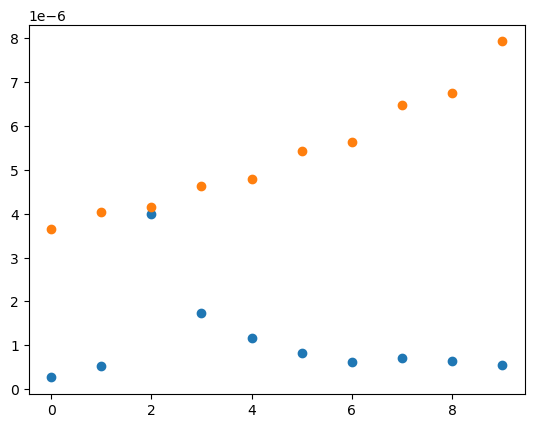

In [92]:
plt.plot(tau,"o")
plt.plot(tau_est,"o")

### Do the same, but calculate average potential first

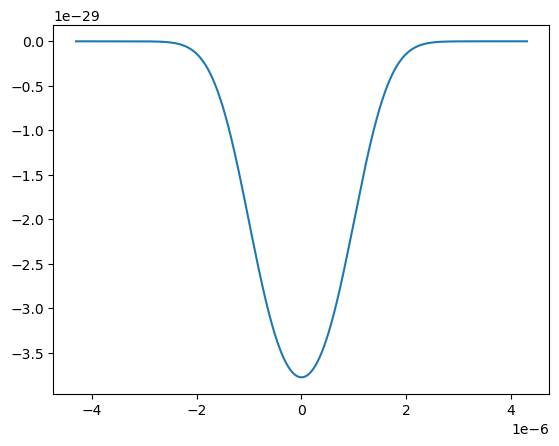

In [93]:
average_pot = sp.lambdify(y,trap.subs(-trap.a*np.sqrt(2/np.pi)/initial_distance*((trap.power_tweezer1/trap.waist_tweezer1*erf((initial_distance-2*y)/np.sqrt(2)/trap.waist_tweezer1)) +
                                                                (trap.power_tweezer2/trap.waist_tweezer2*erf((initial_distance+2*y)/np.sqrt(2)/trap.waist_tweezer2)))))
average_potential = average_pot(x_np)
plt.plot(x_np,average_potential)

mean_ham2 = discrete_hamiltonian(dx,average_potential,float(trap.subs(trap.m).evalf()))


eigenvals2, eigenvects2 = sparse.linalg.eigsh(mean_ham2, k=n_levels, which="LM", sigma=np.min(potential))
eigenvals2_square, eigenvects2_square = sparse.linalg.eigsh(mean_ham2**2, k=n_levels, which="LM", sigma=np.min(potential)**2)

tau2 = const.hbar/np.sqrt(np.abs(eigenvals2_square - eigenvals2**2))

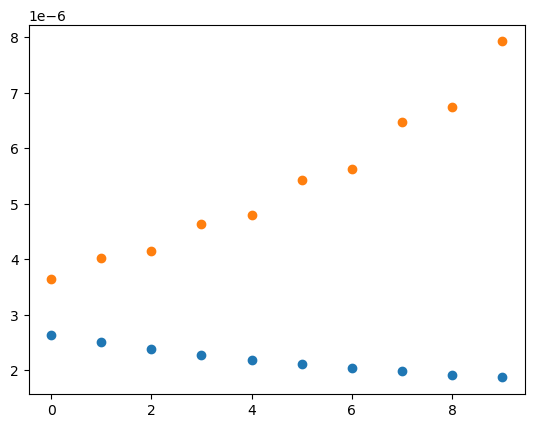

In [94]:
#plt.plot(tau,"o")
plt.plot(tau2,"o")
plt.plot(tau_est,"o")


## Do it actually correctly (implemented in 1st section)

In [95]:
#calculate average potential as tweezer distance is decreased from "initial_distance" to zero
average_pot = sp.lambdify(y,trap.subs(-trap.a*np.sqrt(2/np.pi)/initial_distance*((trap.power_tweezer1/trap.waist_tweezer1*erf((initial_distance-2*y)/np.sqrt(2)/trap.waist_tweezer1)) +
                                                                (trap.power_tweezer2/trap.waist_tweezer2*erf((initial_distance+2*y)/np.sqrt(2)/trap.waist_tweezer2)))))
average_potential = average_pot(x_np)
#plt.plot(x_np,average_potential)

#get the time averaged hamiltonian
mean_ham = discrete_hamiltonian(dx,average_potential,float(trap.subs(trap.m).evalf()))
mean_ham_square = mean_ham**2

#compute the time "tau" needed to make it an adiabatic process
delta_ham = np.zeros(n_levels)
for i, dist in enumerate(distances):
    delta_ham[i] = np.sqrt(states[-1,i].dot(mean_ham_square.dot(states[-1,i]))-(states[-1,i].dot(mean_ham.dot(states[-1,i])))**2)
tau = const.hbar/delta_ham

IndexError: index 10 is out of bounds for axis 1 with size 10

## Try to calculate phase imparted on the states

In [34]:
energies.shape

(150, 10)

In [35]:
states.shape

(150, 10, 2000)

In [36]:
#calculate dynamical phase
dyn_phase = -np.sum(energies,axis=0)/const.hbar

#calculate geometric phase
dot_m = np.gradient(states,axis=0)
bracket_m_dot_m = np.sum(states*np.conjugate(dot_m),axis=2)
geo_phase = 1j*np.sum(bracket_m_dot_m,axis=0)

In [37]:
geo_phase #this can't be correct, since it should be real!!!

array([-0.-0.69885833j, -0.-0.6988583j , -0.-0.94850139j, -0.-0.9485013j ,
       -0.-0.02460082j,  0.+0.02460068j, -0.-0.04092669j,  0.+0.04092651j,
        0.+0.98219236j, -0.-0.98219215j])

In [38]:
dyn_phase

array([47445210.80639105, 46774256.50928428, 44073351.11611445,
       43392945.91945135, 40776693.40224414, 40091176.83504527,
       37560433.80642757, 36872657.12805155, 34428490.8809985 ,
       33740893.13537717])

In [39]:
c_new = 1/np.sqrt(2)*np.array([1,-1])*np.exp(1j*(geo_phase+dyn_phase))
c_new

ValueError: operands could not be broadcast together with shapes (2,) (10,) 